In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(folder, target_size=(256, 256), color_mode='rgb'):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if color_mode == 'grayscale':
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            resized_img = cv2.resize(img, target_size)
            if color_mode == 'grayscale':
                resized_img = np.expand_dims(resized_img, axis=-1)
            images.append(resized_img)
            filenames.append(filename)
    return images, filenames

# Load and preprocess images (color) and labels (grayscale)
train_images, image_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/images/", color_mode='rgb')
train_labels, label_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/labels/", color_mode='grayscale')

# Ensure that images and labels are matched correctly
assert image_filenames == label_filenames, "Mismatch between image and label files"

# Convert lists to numpy arrays for easier manipulation
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Normalize pixel values
train_images = train_images / 255.0
train_labels = np.where(train_labels > 0, 1, 0).astype(np.float32)  # Binarize labels and convert to float32

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
    smooth = 1.0
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.keras.backend.sum(y_true, [1, 2, 3]) + tf.keras.backend.sum(y_pred, [1, 2, 3]) - intersection
    return tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

def unet_vgg16(input_size=(256, 256, 3)):  # Change input size to 3 channels
    inputs = Input(input_size)

    # Encoder (VGG16)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(256, 256, 3)))
    vgg16.trainable = False

    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output

    bridge = vgg16.get_layer("block5_conv3").output

    # Decoder
    d1 = UpSampling2D((2, 2))(bridge)
    d1 = concatenate([d1, s4])
    d1 = Conv2D(512, (3, 3), padding='same', activation='relu')(d1)
    d1 = Conv2D(512, (3, 3), padding='same', activation='relu')(d1)

    d2 = UpSampling2D((2, 2))(d1)
    d2 = concatenate([d2, s3])
    d2 = Conv2D(256, (3, 3), padding='same', activation='relu')(d2)
    d2 = Conv2D(256, (3, 3), padding='same', activation='relu')(d2)

    d3 = UpSampling2D((2, 2))(d2)
    d3 = concatenate([d3, s2])
    d3 = Conv2D(128, (3, 3), padding='same', activation='relu')(d3)
    d3 = Conv2D(128, (3, 3), padding='same', activation='relu')(d3)

    d4 = UpSampling2D((2, 2))(d3)
    d4 = concatenate([d4, s1])
    d4 = Conv2D(64, (3, 3), padding='same', activation='relu')(d4)
    d4 = Conv2D(64, (3, 3), padding='same', activation='relu')(d4)

    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d4)

    model = Model(inputs=vgg16.input, outputs=outputs)
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', dice_coefficient, iou, precision, recall, f1_score])
    
    return model

# Create the model
model = unet_vgg16()
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    batch_size=16, 
                    verbose=1,
                    callbacks=[early_stopping])

# Check if early stopping was triggered
if len(history.history['val_loss']) < 100:
    print("Early stopping was triggered. Training stopped early.")
else:
    print("Training completed without early stopping.")

# Save the model
model.save("unet_vgg16_model.h5")
print("Model saved as unet_vgg16_model.h5")


C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 24,891,137 (94.95 MB)

 Trainable params: 10,176,449 (38.82 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 13s/step - accuracy: 0.4741 - dice_coefficient: 0.3400 - f1_score: 0.3020 - iou: 0.2228 - loss: 7.4590 - precision: 0.3043 - recall: 0.5387 - val_accuracy: 0.4553 - val_dice_coefficient: 0.6235 - val_f1_score: 0.6257 - val_iou: 0.4528 - val_loss: 2.3765 - val_precision: 0.4553 - val_recall: 1.0000
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - accuracy: 0.3958 - dice_coefficient: 0.5528 - f1_score: 0.5644 - iou: 0.3805 - loss: 1.9387 - precision: 0.3940 - recall: 0.9985 - val_accuracy: 0.5437 - val_dice_coefficient: 0.3434 - val_f1_score: 0.0259 - val_iou: 0.2056 - val_loss: 0.7898 - val_precision: 0.4585 - val_recall: 0.0133
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - accuracy: 0.6105 - dice_coefficient: 0.3488 - f1_score: 0.1238 - iou: 0.2013 - loss: 0.7055 - precision: 0.4554 - recall: 0.0975 - val_accuracy: 0.7654 - val_dice_coefficient: 0.6435 - val_f1_score: 0.7932 - val_iou: 0.4702 - val_loss: 0.5570 - val_precision: 0.6623 -

Early stopping was triggered. Training stopped early.
Model saved as unet_vgg16_model.h5


In [3]:
# Print the final metrics
final_metrics = {
    "accuracy": history.history['accuracy'][-1],
    "val_accuracy": history.history['val_accuracy'][-1],
    "loss": history.history['loss'][-1],
    "val_loss": history.history['val_loss'][-1],
    "dice_coefficient": history.history['dice_coefficient'][-1],
    "val_dice_coefficient": history.history['val_dice_coefficient'][-1],
    "iou": history.history['iou'][-1],
    "val_iou": history.history['val_iou'][-1],
    "precision": history.history['precision'][-1],
    "val_precision": history.history['val_precision'][-1],
    "recall": history.history['recall'][-1],
    "val_recall": history.history['val_recall'][-1],
    "f1_score": history.history['f1_score'][-1],
    "val_f1_score": history.history['val_f1_score'][-1]
}

for metric, value in final_metrics.items():
    print(f"{metric}: {value}")

accuracy: 0.9749115109443665
val_accuracy: 0.9683380126953125
loss: 0.05951816961169243
val_loss: 0.07722262293100357
dice_coefficient: 0.9527158737182617
val_dice_coefficient: 0.9536968469619751
iou: 0.9015336036682129
val_iou: 0.911563515663147
precision: 0.9709903597831726
val_precision: 0.9635101556777954
recall: 0.9633479118347168
val_recall: 0.9670754671096802
f1_score: 0.9671061635017395
val_f1_score: 0.9652894139289856


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


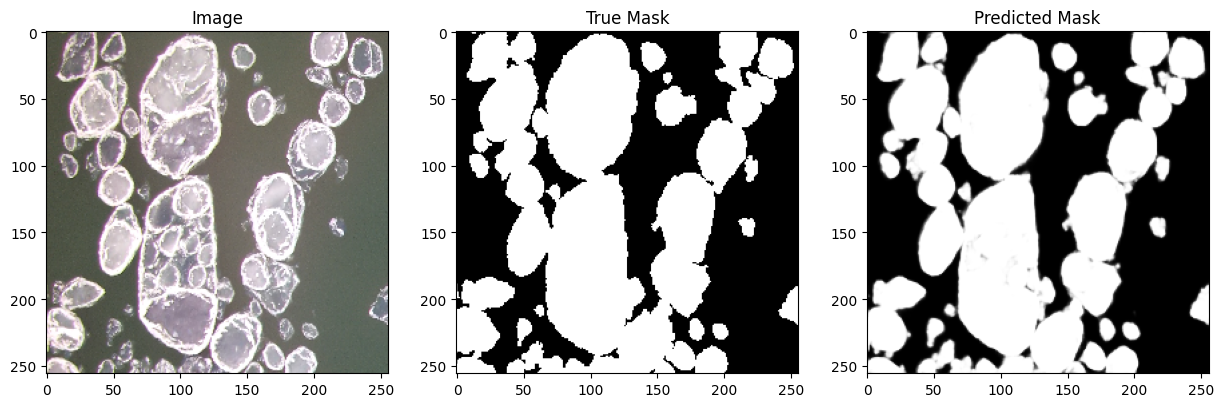

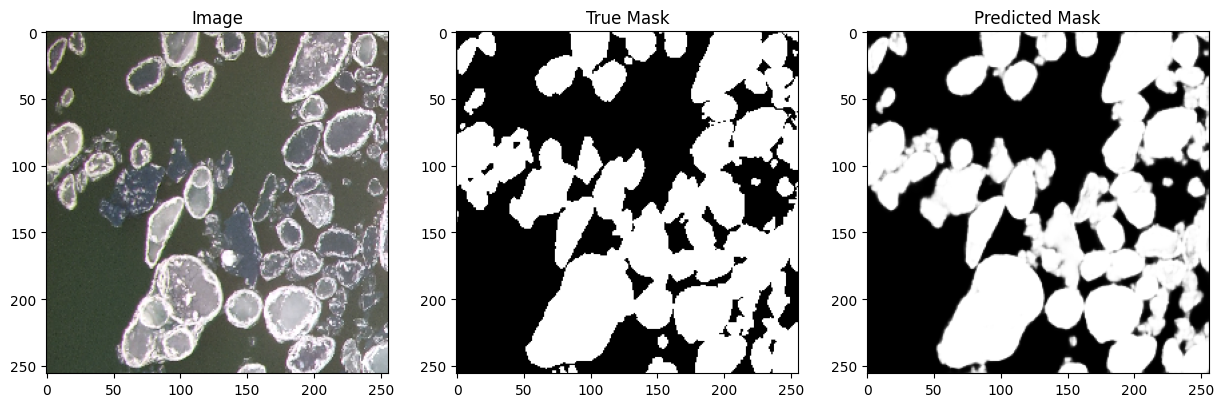

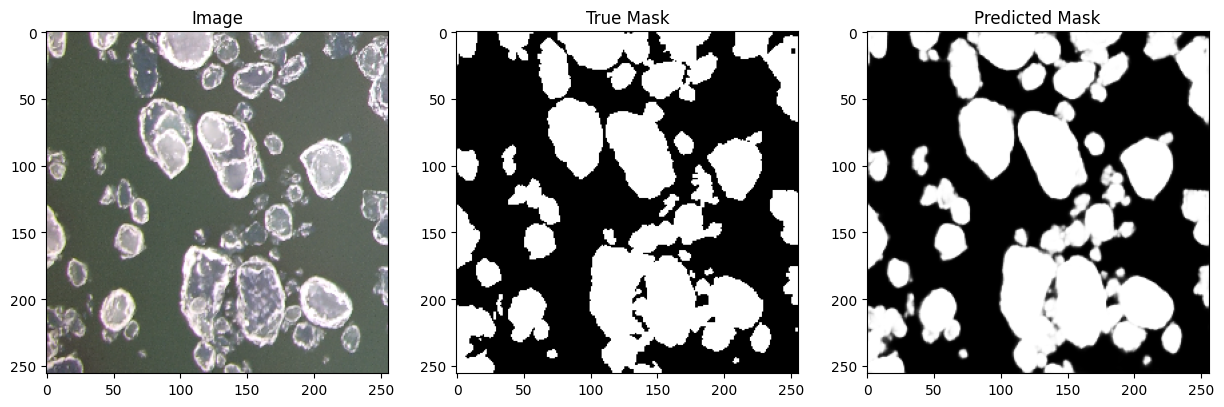

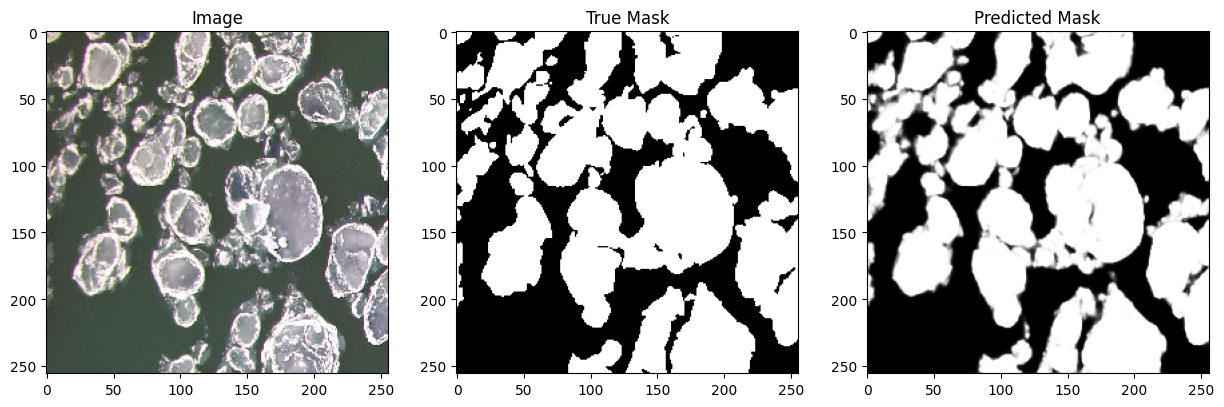

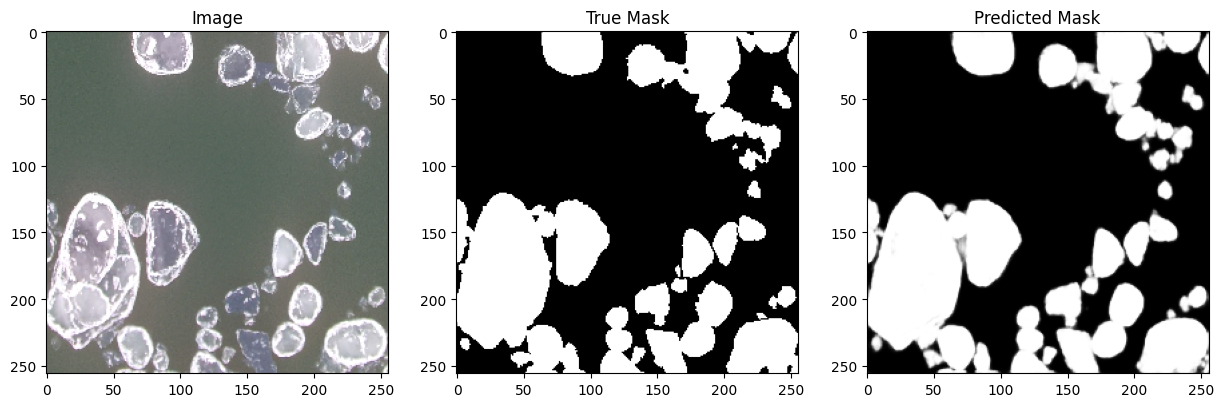

In [4]:
# Predict segmentation masks for validation images
predicted_masks = model.predict(X_val)

# Plotting some results
import matplotlib.pyplot as plt

def plot_results(img, true_mask, pred_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.show()

# Visualize some results
for i in range(5):  # Plot first 5 results
    plot_results(X_val[i], y_val[i], predicted_masks[i])

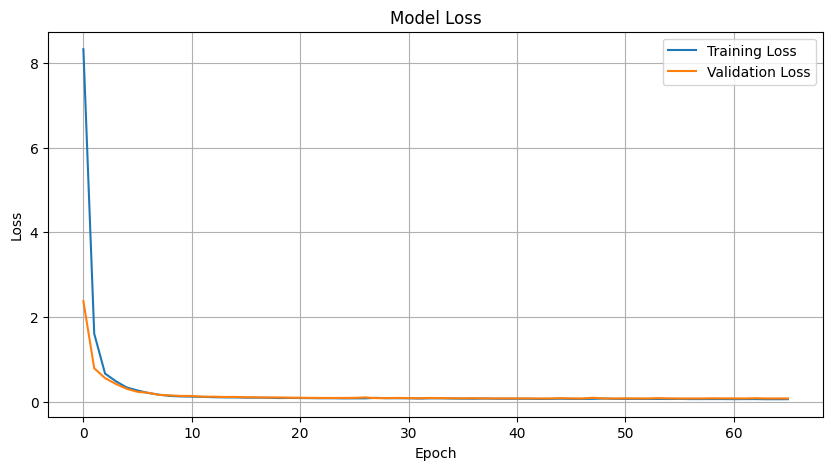

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()